In [4]:
# https://shorturl.at/nyzL4
# https://shorturl.at/FO479
import gymnasium as gym
import math
import random
import copy
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns; sns.set()

In [5]:
env = gym.make("BipedalWalker-v3") #Setting up an existing open AI gym environment
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

    plt.ion()
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU acceleration 

In [6]:
""" Represents a single transition in the environment. Used for experience replay. """
Experience = namedtuple('Experience',                                       
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory:
    """Fixed-size memory buffer to store Experience tuples."""
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Experience(*args))
    
    def sample(self, batch_size):
        """ Selects a random batch of transitions for training"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    """
    Deep Q-Network model
    """
    def __init__(self, state_size, action_size, seed):
        """
        Initialize parameters and construct DQN model
        
        @param state_size(int) : Dimensions of each state
        @param action_size(int): Dimensions of each action
        @param seed            : Random seed
        """
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,64)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, 48)
        self.fc4_1 = nn.Linear(48, action_size)
        self.fc4_2 = nn.Linear(48, action_size)
        self.fc4_3 = nn.Linear(48, action_size)
        self.fc4_4 = nn.Linear(48, action_size)
        
    def forward(self, state):
        """
        Forward propagation of the network
        
        @param state: state
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred1 = self.fc4_1(x) # shape: (20,)
        pred2 = self.fc4_2(x)
        pred3 = self.fc4_3(x)
        pred4 = self.fc4_4(x)
        return pred1, pred2, pred3, pred4 

In [59]:
""" Hyperparameters (Maybe receive these as arguments? (parse_args))"""
MEMORY_SIZE = int(5e4)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
EPSILON = 1.0
EPSILON_MIN = 0.05
EPS_DECAY = 1e-3
UPDATE_EVERY = 4

class Agent():
    """
    Agent that interacts and learns from the environment.
    Receives rewards from the environment, update DQN parameters, "memorize" experiences.
    """
    def __init__(self, state_space, action_space, disc_class, seed):
        """
        Initialize parameters and construct an Agent object
        
        @param state_size(int) : Dimensions of each state
        @param action_size(int): Dimensions of each action
        @param seed            : Random seed
        """
        self.state_space = state_space
        self.action_space = action_space
        self.disc_class = disc_class
        self.seed = random.seed(seed)
        
        # Initalize main and target DQN 
        self.main_model = DQN(state_space.shape[0], disc_class, seed).to(device)
        self.target_model = DQN(state_space.shape[0], disc_class, seed).to(device)
        
        self.optimizer = optim.Adam(self.main_model.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayMemory(MEMORY_SIZE)
        
        # Initialize time step (for updating every UPDATE_EVERY step)
        self.t_step = 0
        self.eps_step = 0
        self.spacing = 0.1
    
    def add_memory(self, state, action, next_state, reward):
        # save experience in replay memory
        self.memory.push(state, action, next_state, reward)
        
    def choose_action(self, state):
        """
        Return action for given state following the current policy
        
        @param state: Current state
        @param epsilon(float)  : epsilon for epsilon-greedy action selection
        """
        eps_threshold = EPSILON_MIN + (EPSILON - EPSILON_MIN) * math.exp(-1 * self.eps_step / EPS_DECAY)
        self.eps_step += 1
        # epsilon-greedy action selection
        if random.random() > eps_threshold:
            with torch.no_grad():
                pred1, pred2, pred3, pred4 = self.main_model(state)
                pred1 = np.argmax(pred1)
                pred2 = np.argmax(pred2)
                pred3 = np.argmax(pred3)
                pred4 = np.argmax(pred4)
                action = torch.tensor((pred1, pred2, pred3, pred4))
                assert(0 <= pred1 and pred1 <= 19 and
                       0 <= pred2 and pred2 <= 19 and
                       0 <= pred3 and pred3 <= 19 and
                       0 <= pred4 and pred4 <= 19)
                # print("max:",action, action.shape)
                return action
        else:
            action = torch.randint(0, 20, (4,))
            assert(0 <= action[0] and action[0] <= 19 and
                   0 <= action[1] and action[1] <= 19 and
                   0 <= action[2] and action[2] <= 19 and
                   0 <= action[3] and action[3] <= 19)
            # print("random:", action, action.shape)
            return action
        
    def disct2cont(self,action):
        return action * self.spacing - self.action_space.high
    
    def cont2disc(self, action):
        ''' converts continuous action valeus back to indices '''
        res = [ ]
        for i in range(len(action)):
            res.append(pd.cut(action[i] , bins = np.linspace(-1.0, 1.0, num=21, endpoint = True), labels = np.arange(20), include_lowest=True, right= True))
        return res
    
    def learn(self):
        """
        Update parameters using the given batch of expreience tuples
        
        @param experiences(Tuple): tuple of (s,a,s',r) tuples
        @param gamma(float): discount factor
        """
        if len(self.memory) < BATCH_SIZE:
            return
        
        self.update_target()
        experiences = self.memory.sample(BATCH_SIZE)
        batch = Experience(*zip(*experiences)) # This converts batch-array of Experiences
                                               # to Experience of batch-arrays.
        #batch.action --> (batch_size, tensor(4,))               ==> (64, tensor(4,))
        #batch.state --> (batch_size, tensor(1,state_size))      ==> (64, tensor(1,24))
        #batch.next_state --> (batch_size, tensor(1,state_size)) ==> (64, tensor(1,24))
        #batch.reward --> (batch_size, tensor(1))                ==> (64, tensor(1))
        action_indicies = self.cont2disc(batch.action)
        action_indicies_t = torch.tensor(list(zip(*action_indicies)))   # list(4,64)
        state_batch = torch.cat(batch.state)           # tensor(64, state_size)
        next_state_batch = torch.cat(batch.next_state) # tensor(64, state_size)
        reward_batch = torch.cat(batch.reward) # shape (64, )
        rewards = reward_batch.repeat(4,1) # shape: tensor(4,64)

        self.main_model.train() # Set local network as training mode
        self.target_model.eval() # Set target network as evaluation mode

        # Compute Q(s_t, a) - the model computes Q(s_t)
        state_values = torch.stack(list(self.main_model(state_batch)), dim = 0) # changing tuple to tensor shape: tensor(4,64,20)
        state_action_values = torch.gather(state_values, 2, action_indicies_t.unsqueeze(-1)) # extracting q_values based on actions

        q_eval = torch.squeeze(state_action_values)


        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        q_next = self.target_model(next_state_batch) # shape: tuple (4, tensor(64,20))
        q_next_max = torch.zeros(4,64)
        for i in range(len(q_next_max)):
            q_next_max[i] = torch.amax(q_next[i],dim=1)
        q_target = rewards + GAMMA * q_next_max # (4,64)
        # print(f"q_eval:{q_eval}\n")
        # print(f"q_target:{q_target}\n")
        loss = F.smooth_l1_loss(q_eval, q_target)
        # print("loss is:",loss)
        assert(loss.requires_grad_())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        loss_value = loss.item()
        self.t_step += 1
        """ UPDATE TARGET NETWORK Don't update every step (compare) """ 
        # self.soft_update(self.main_model, self.target_model, TAU)
        # print("AFTER loss is:",loss_value)
        return loss_value

    def update_target(self):
        if self.t_step % 100 == 0:
            self.target_model.load_state_dict(self.main_model.state_dict())
        
    
    def soft_update(self, main_model, target_model, tau):
        """
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        @param local_model(nn model): weights will be copied from
        @param target_model(nn model): weights will be copied to
        @param tau(float): interpolation parameter
        """
        for target_param, main_param in zip(target_model.parameters(), main_model.parameters()):
            target_param.data.copy_(tau*main_param.data + (1.0-tau)*target_param.data)

In [60]:
def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

Episode 1
Average Score -113.37
Episode 2
Average Score -106.69
Episode 3
Average Score -106.22
Episode 4
Average Score -104.41
Episode 5
Average Score -103.96
Episode 6
Average Score -101.96
Episode 7
Average Score -101.85
Episode 8
Average Score -101.93
Episode 9
Average Score -102.07
Episode 10
Average Score -102.35
Episode 11
Average Score -102.49
Episode 12
Average Score -102.64
Episode 13
Average Score -102.23
Episode 14
Average Score -102.33
Episode 15
Average Score -102.65
Episode 16
Average Score -104.36
Episode 17
Average Score -104.23
Episode 18
Average Score -104.02
Episode 19
Average Score -103.82
Episode 20
Average Score -104.88
Episode 21
Average Score -105.11
Episode 22
Average Score -104.85
Episode 23
Average Score -104.59
Episode 24
Average Score -104.51
Episode 25
Average Score -104.36
Episode 26
Average Score -104.23
Episode 27
Average Score -104.11
Episode 28
Average Score -104.61
Episode 29
Average Score -104.45
Episode 30
Average Score -104.16
Episode 31
Average 

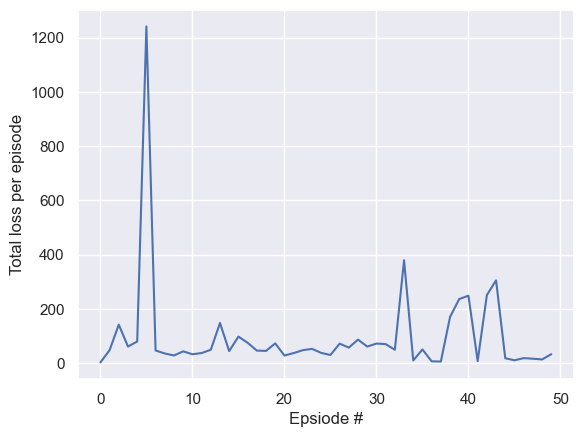

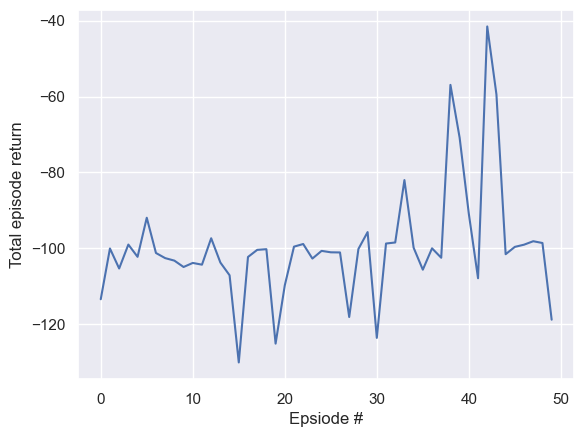

In [61]:
agent = Agent(state_space = env.observation_space, action_space = env.action_space, disc_class = 20, seed = 0)

def train(n_episodes = 50, max_t =1600):
    """
    Training DQN
    
    @param n_episodes(int): Number of training episodes
    @param max_t(int):      Maximum number of timesteps per episode
    eps_start(float):       Starting value of epsilon for epsilon-greedy action selection
    eps_end(float):         Minimum value of epsilon
    eps_dec(float):         Multiplicative factor for decrementing epsilon
    """
    # For plotting
    scores = [ ]
    losses = [ ]
    scores_window = deque(maxlen=100) 
    for episode in range(1,n_episodes+1):
        print('\rEpisode {}'.format(episode), end="\n")
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        state = F.normalize(state)
        score = 0
        tot_loss = 0
        done = False
        for t in range(max_t):
            index = agent.choose_action(state)
            action = agent.disct2cont(index)
            
            next_observation, reward, done, truncated, _  = env.step(action)
            next_state = torch.tensor(next_observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = F.normalize(next_state)
            score += reward
            reward = torch.tensor([reward],device = device)
            # print(len(agent.memory))
            if len(agent.memory) < 256:
                agent.add_memory(state, action, next_state, reward)
            state = next_state
            loss = agent.learn()
            if loss is not None: tot_loss += loss
            if done:
                break
        # For plotting
        losses.append(tot_loss)
        scores_window.append(score)
        scores.append(score)
        print('\rAverage Score {:.2f}'.format(np.mean(scores_window)), end="\n")
        if score > 300:
            print(f"Environment solved! t:{t}, episode:{episode}")
            break
    return scores, losses

scores, losses = train()
# plot_returns(scores)
# plot_returns(losses)
#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(losses)),losses)
plt.ylabel('Total loss per episode')
plt.xlabel('Epsiode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Total episode return')
plt.xlabel('Epsiode #')
plt.show()
                